Written by Zain Kamal [zain.eris.kamal@rutgers.edu](mailto:zain.eris.kamal@rutgers.edu) on 06/24/2023.

https://github.com/Humboldt-Penguin/redplanet

---
---
## Section 1


### Data Source

Raw data downloaded from here: https://zenodo.org/record/6477509 (which itself is a supplement to https://doi.org/10.1029/2022JE007298).

Description:

>    `dichotomy/`
> 
>    **Spherical harmonic coefficients of the shape of the crust-mantle interface**. The file names are of the format "Moho-Mars-MODEL-THICK-RHOS-RHON.sh", where RHOS and RHON are respectively the densities south and north of the dichotomy boundary. When RHOS and RHON are equal, the model corresponds to the constant density model in the directory "constant" (note that the numerical values are not identical as a result of using two different numerical approaches).

The software package as a whole is incredibly useful, but its main flaws are that (1) generating a single dataset can take ~1.5-2 minutes, 95% of which is spent writing the file to disk (after it is already loaded), and (2) generating datasets for multiple models is a separate process from running the code that analyzes it. We seek to optimize this so users can **quickly load datasets based on custom parameters on the fly**.

---

### Downloading Raw Data

This data itself is hosted in a Google Drive folder titled `moho_SHcoeffs/`: https://drive.google.com/drive/u/0/folders/1CdSN1fTXzfKlWtfIM-rbties3lJPDkZS (more specifically, we zip `dichotomy/` from Wieczorek's code, upload it to Google Drive, and then use the cloud-based zip extractor tool -- Google Drive does not play well with uploading a lot of files via HTTP).

There are a ton of raw data files here. In total, there's 21,894 files (4.76 GB, each is 229 KB). Rather than force the user to store everything locally, they can selectively download the model they need. In order to do this, we use a Google Drive "Apps Script" in order to enumerate all filenames + shareable links into a Google Sheet. This code is a modified version from this thread: https://webapps.stackexchange.com/questions/88769/get-share-link-of-multiple-files-in-google-drive-to-put-in-spreadsheet.

Steps:
1. Open the desired Google Drive folder, set share settings to "anyone with the link", and get its ID in the URL from the browser location bar: 
    https://drive.google.com/drive/u/0/folders/<id>
2. Open a new Google Sheet and navigate `Extensions > Apps Script`.
3. Copy/paste the script below, replace `<id>` with the folder ID (for this work, `1-Nip0C4-Rx4AYBDfMfmjpTcxyKTclOqk`), and run the code (make sure to click "Run" and not "Deploy").
4. The Google Sheet should now contain relevant data (for this work, https://docs.google.com/spreadsheets/d/1dLblk88HpLZdk1Wg_eoV5V7MEvne6OE63DcXG7G68pw/edit#gid=0). We download this as `redplanet-data/

In [87]:
from redplanet import utils
import pyshtools as pysh
import numpy as np
import gdown
import pooch
import json

# url = 'https://drive.google.com/file/d/1lCNzUSAUhysjBnn62PldByzvLEhpKo_K/view?usp=drivesdk' # nah this prints some weird shit
# url = 'https://drive.google.com/uc?export=download&id=1lCNzUSAUhysjBnn62PldByzvLEhpKo_K' # another strange warning
# url = 'ftp://1lCNzUSAUhysjBnn62PldByzvLEhpKo_K@drive.google.com'

# model_name = 'Khan2022-49-3000-3050'
model_name = 'DWThot-30-2750-2950'
grid_spacing = 10



RIM_str = model_name[:utils.indexOf(model_name,'-',n=0)]

insight_thickness = model_name[
    utils.indexOf(model_name,'-',n=0)+1 : 
    utils.indexOf(model_name,'-',n=1)
]

rho_south = model_name[
    utils.indexOf(model_name,'-',n=1)+1 : 
    utils.indexOf(model_name,'-',n=2)
]

rho_north = model_name[
    utils.indexOf(model_name,'-',n=2)+1 :
]






'''load a pre-computed registry, which maps a model name to a google drive download link and a sha256 hash'''
with open('rawdata_registry.json', 'r') as file:
    rawdata_registry = json.load(file)



'''download file from pooch'''
def download_gdrive_file(url, output_file, pooch):
    '''Helper for `pooch.retrieve` to allow for downloading from Google Drive.'''
    gdown.download(url, output_file, quiet=True, fuzzy=True)



logger = pooch.get_logger()
logger.disabled = True


filepath_shcoeffs = pooch.retrieve(
    url=rawdata_registry[model_name]['link'], 
    known_hash=rawdata_registry[model_name]['hash'], 
    # fname=model_name, # we choose to omit this because there's no point to keeping it...! it literally only creates a chance for overwriting lol
    path=pooch.os_cache('redplanet'), 
    downloader=download_gdrive_file, 
)











'''parameters'''
lmax = round(90. / grid_spacing - 1)
grid_spacing = 180. / (2 * lmax + 2)
n = 2*(lmax + 1)




'''load 3 'grid'-type objects'''
topo = pysh.datasets.Mars.MarsTopo2600(lmax=lmax)
topo_grid = topo.expand(grid='DH2', extend=True) / 1.e3

moho = pysh.SHCoeffs.from_file(filepath_shcoeffs)
moho_grid = moho.expand(lmax=lmax, grid='DH2', extend=True) / 1.e3

thick_grid = topo_grid - moho_grid




'''save numpy arrays'''
dat_topo = topo_grid.to_array()
dat_moho = moho_grid.to_array()
dat_thick = thick_grid.to_array()

lons = utils.clon2lon(topo_grid.lons())
lats = topo_grid.lats()





'''rearrange: gridded data is originally in clon 0->360, and we converted to lon, so the current order is lon 0->180/-180->0. we want to convert to lon -180->180, so we rearrange columns.'''
i_left = np.where(lons == -180)[0][0]

lons = np.hstack((lons[i_left:], lons[:i_left]))
dat_topo = np.hstack((dat_topo[:,i_left:], dat_topo[:,:i_left]))
dat_moho = np.hstack((dat_moho[:,i_left:], dat_moho[:,:i_left]))
dat_thick = np.hstack((dat_thick[:,i_left:], dat_thick[:,:i_left]))



'''rearrange: flip lats so they're increasing'''
lats = np.flip(lats)
dat_topo = np.flip(dat_topo, axis=0)
dat_moho = np.flip(dat_moho, axis=0)
dat_thick = np.flip(dat_thick, axis=0)




'''edge case: lon is actually from -180->179, so we pad to -180->181 VIA *WRAPAROUND* (extra 1 degree on right side is for later bilinear interpolation alg).'''
lons = np.array( (*lons, lons[-1]+grid_spacing, lons[-1]+grid_spacing*2) )
dat_topo = np.hstack( (dat_topo, dat_topo[:,0:1], dat_topo[:,1:2] ) )
dat_moho = np.hstack( (dat_moho, dat_moho[:,0:1], dat_moho[:,1:2] ) )
dat_thick = np.hstack( (dat_thick, dat_thick[:,0:1], dat_thick[:,1:2] ) )


'''edge case: lat is actually from -90->90, so we pad to -90->91 VIA *DUPLICATION* (extra 1 degree on top side is for later bilinear interpolation alg).'''
lats = np.array( (*lats, lats[-1]+grid_spacing) )
dat_topo = np.vstack( (dat_topo, dat_topo[-1:,:]) )
dat_moho = np.vstack( (dat_moho, dat_moho[-1:,:]) )
dat_thick = np.vstack( (dat_thick, dat_thick[-1:,:]) )


In [119]:
i = np.searchsorted(lats, 90, side='right') - 1
lats[i]

90.0

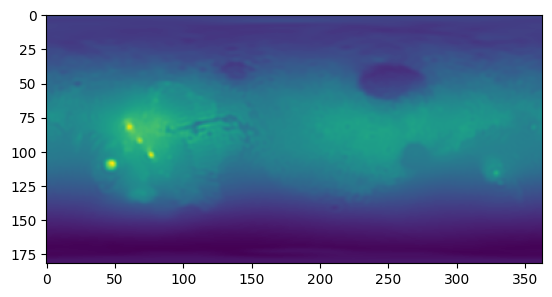

In [81]:
import matplotlib.pyplot as plt
plt.imshow(dat_topo)

In [53]:
# np.vstack( (dat_topo[i_left:], dat_topo, dat_topo[:i_left]) )

lon=-180
i = np.searchsorted(lons, lon) - 1
print(lons[i])

lat=31.1234
j = lats.shape[0] - np.searchsorted(np.flip(lats), lat)
print(lats[j])

-190.0
30.0


In [52]:
lons

array([-190., -180., -170., -160., -150., -140., -130., -120., -110.,
       -100.,  -90.,  -80.,  -70.,  -60.,  -50.,  -40.,  -30.,  -20.,
        -10.,    0.,    0.,   10.,   20.,   30.,   40.,   50.,   60.,
         70.,   80.,   90.,  100.,  110.,  120.,  130.,  140.,  150.,
        160.,  170.,  180.])

In [82]:
print(lons)

print(lons.shape)

print(dat_topo[:,-1].shape)
print(dat_topo.shape)
print(dat_topo[:,0].shape)



# np.vstack( (dat_topo[:,-1][:, np.newaxis], dat_topo, dat_topo[:,0][:, np.newaxis]) )

x = np.concatenate((dat_topo[:,-1][:, np.newaxis], dat_topo, dat_topo[:,0][:, np.newaxis]), axis=1)

x[0,0] == x[0,-2]
# left_edge = dat_topo[0, :]
# right_edge = dat_topo[-1, :]
# this_data = np.array([right_edge, *dat_topo, left_edge])


# this_data2 = np.array([(dat_topo[-1, :]), *dat_topo, (dat_topo[0, :])])

# this_data == this_data2

[-190. -180. -170. -160. -150. -140. -130. -120. -110. -100.  -90.  -80.
  -70.  -60.  -50.  -40.  -30.  -20.  -10.    0.    0.   10.   20.   30.
   40.   50.   60.   70.   80.   90.  100.  110.  120.  130.  140.  150.
  160.  170.  180.]
(39,)
(19,)
(19, 37)
(19,)


True

In [6]:
import numpy as np
# lons = np.array([lons[0]-grid_spacing, *lons, lons[-1]+grid_spacing])

In [17]:
print(lons.shape)
print(dat_topo.shape)

(361,)
(181, 361)


In [28]:
lon = 15

i = np.searchsorted(lons, lon)

lons[i]

15.0

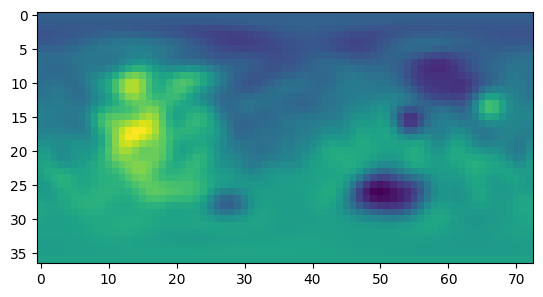

In [5]:
import matplotlib.pyplot as plt

plt.imshow(dat_thick)

In [3]:
"""load `moho_SHcoeffs_LINKS.csv` into dictionary"""

file_path = r'C:\Users\Eris\Downloads\redplanet-data\Crust\1_raw\moho_SHcoeffs_LINKS.csv'



import csv
def load_csv_to_dictionary(file_path: str) -> dict:
    dictionary = {}
    with open(file_path, 'r') as csv_file:
        reader = csv.reader(csv_file)
        for row in reader:
            # if len(row) >= 2:  # Ensure the row has at least two columns
            key = row[0]
            value = row[1]
            # dictionary[key]['download_link'] = value
            dictionary[key] = value
    return dictionary


dat = load_csv_to_dictionary(file_path)





"""pre-generate dictionary for accessing download link/hash based on model name"""



path_folder = r'C:\Users\Eris\Documents\sync_local\00_Local\mars\scripts\InSight-Crustal-Thickness-Archive\dichotomy'

rawdata_registry = {}


import os
import pooch
from redplanet import utils

i = 0

for filename in os.listdir(path_folder):
    this_link = dat[filename]

    this_hash = pooch.file_hash(fname=os.path.join(path_folder, filename), alg='sha256')
    this_hash = f'sha256:{this_hash}'

    model_name = filename[10: utils.indexOf(filename, '.sh')]
    rawdata_registry[model_name] = {'link': this_link, 'hash': this_hash}

    i+=1
    if i % 100 == 0:
        print(i)


"""save"""

import json

with open("rawdata_registry.json", "w") as file:
    file.write(json.dumps(rawdata_registry))

100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
10000
10100
10200
10300
10400
10500
10600
10700
10800
10900
11000
11100
11200
11300
11400
11500
11600
11700
11800
11900
12000
12100
12200
12300
12400
12500
12600
12700
12800
12900
13000
13100
13200
13300
13400
13500
13600
13700
13800
13900
14000
14100
14200
14300
14400
14500
14600
14700
14800
14900
15000
15100
15200
15300
15400
15500
15600
15700
15800
15900
16000
16100
16200
16300
16400
16500
16600
16700
16800
16900
17000
17100
17200
17300
17400
17500
17600
17700
17800
17900
18000
18100
18200
18300
18400
1850

In [10]:
rawdata_registry

NameError: name 'rawdata_registry' is not defined

In [14]:
pooch.file_hash('rawdata_registry.json', alg='sha256')

'1800ee2883dc6bcc82bd34eb2eebced5b59fbe6c593cbc4e9122271fd01c1491'

In [1]:
from redplanet import GRS

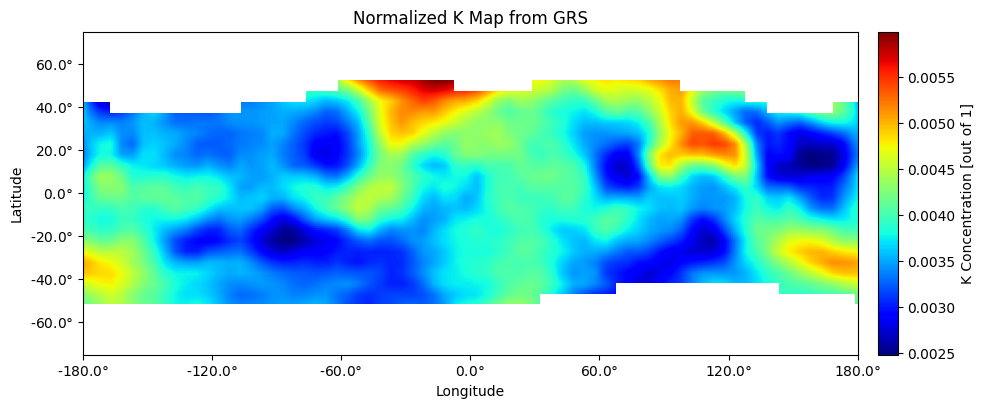

In [3]:
GRS.visualize('k', grid_spacing=1, normalize=True)

In [16]:
import pyshtools as pysh
from redplanet import utils
import numpy as np

grid_spacing = 0.1

In [23]:


lmax = round(90. / grid_spacing - 1)
grid_spacing = 180. / (2 * lmax + 2)

topo = pysh.datasets.Mars.MarsTopo2600(lmax=lmax)
topo_grid = topo.expand(grid='DH2', extend=True) / 1.e3

lons = utils.clon2lon(topo_grid.lons())
lats = topo_grid.lats()
dat_topo = topo_grid.to_array()

i_left = np.where(lons == -180)[0][0]
lons = np.hstack((lons[i_left:], lons[:i_left]))
dat_topo = np.hstack((dat_topo[:,i_left:], dat_topo[:,:i_left]))
lats = np.flip(lats)
dat_topo = np.flip(dat_topo, axis=0)
lons = np.array( (*lons, lons[-1]+grid_spacing, lons[-1]+grid_spacing*2) )
dat_topo = np.hstack( (dat_topo, dat_topo[:,0:2] ) )
lats = np.array( (*lats, lats[-1]+grid_spacing) )
dat_topo = np.vstack( (dat_topo, dat_topo[-1:,:]) )

In [1]:
from redplanet import Crust

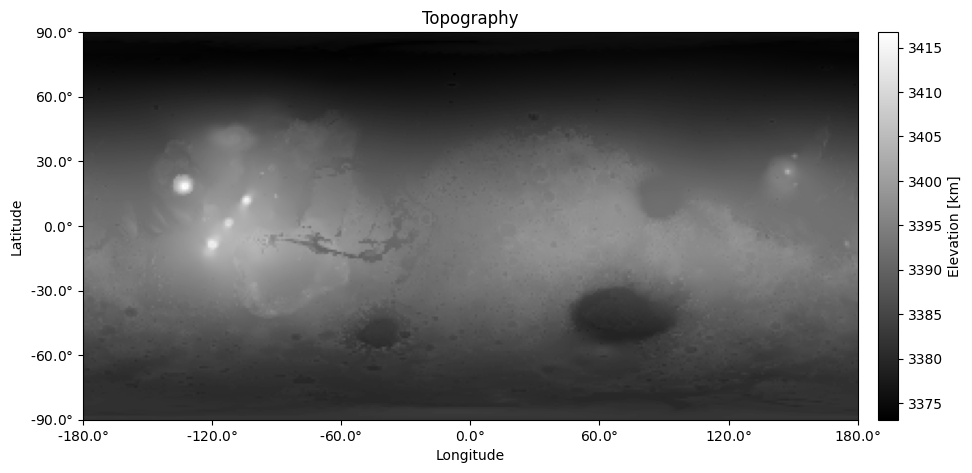

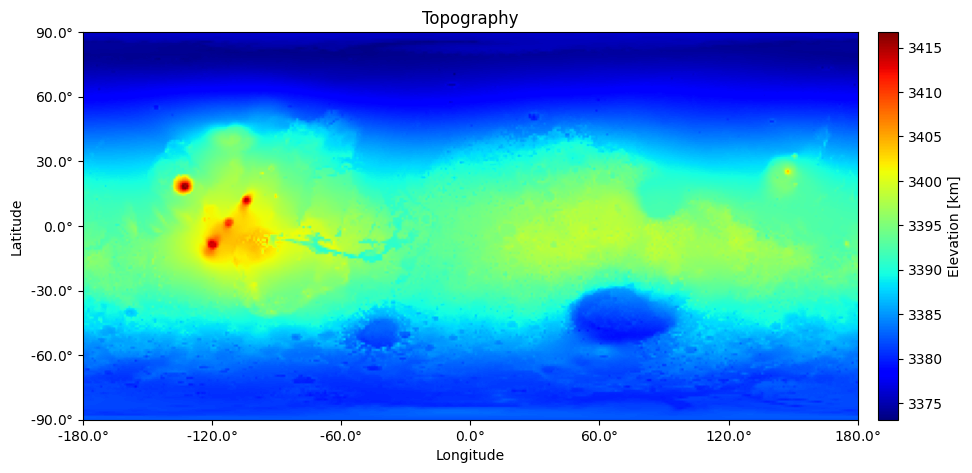

In [2]:
Crust.visualize('topo')
Crust.visualize('topo', colormap='jet')

In [9]:
Crust.load_model(RIM='Khan2022', insight_thickness=39, rho_north=2900, rho_south=2900)

True

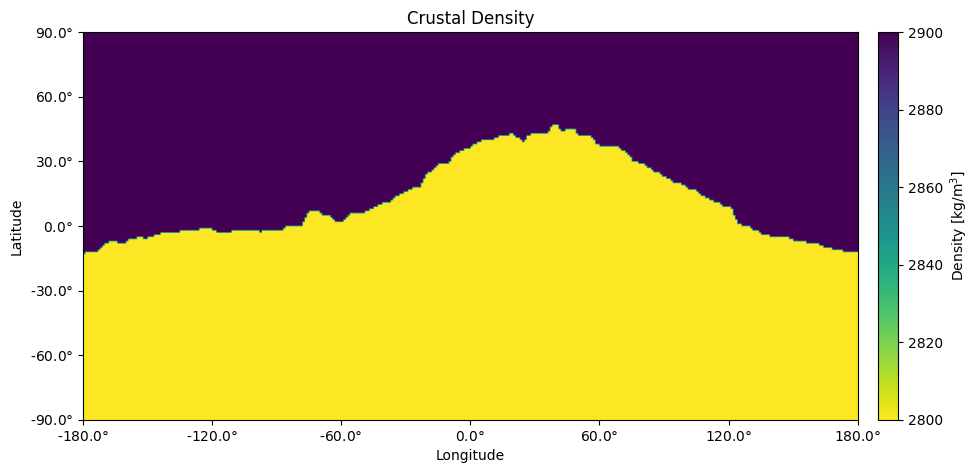

In [4]:
Crust.visualize('rho')

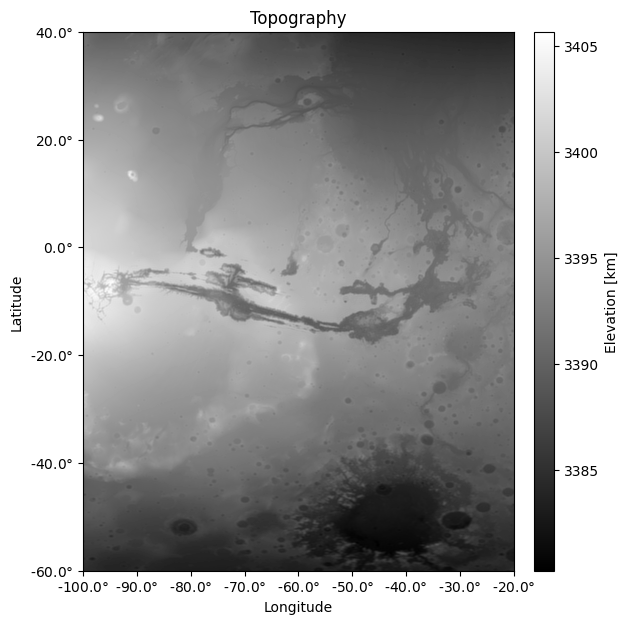

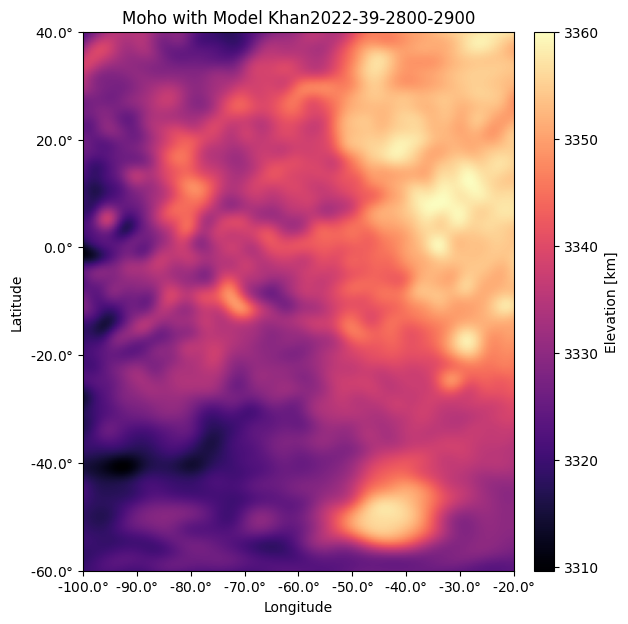

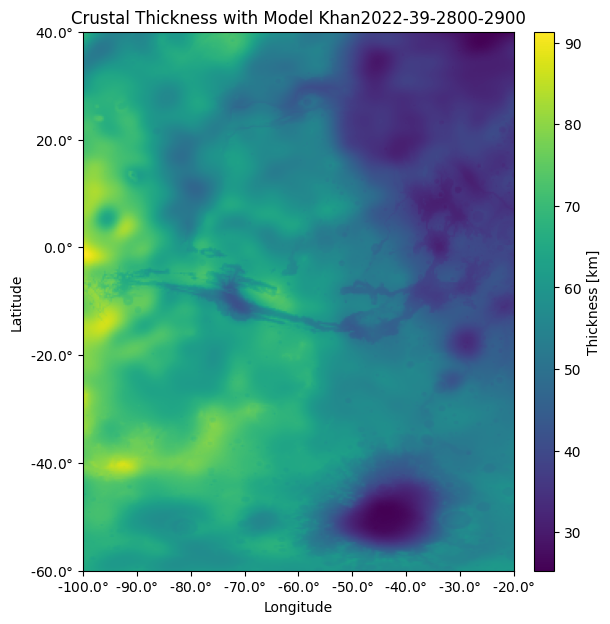

In [6]:
lon = (-100,-20)
lat = (-60,40)

Crust.visualize('topo', lon_bounds=lon, lat_bounds=lat, grid_spacing=0.1)
Crust.visualize('moho', lon_bounds=lon, lat_bounds=lat, grid_spacing=0.3)
Crust.visualize('thick', lon_bounds=lon, lat_bounds=lat, grid_spacing=0.3)

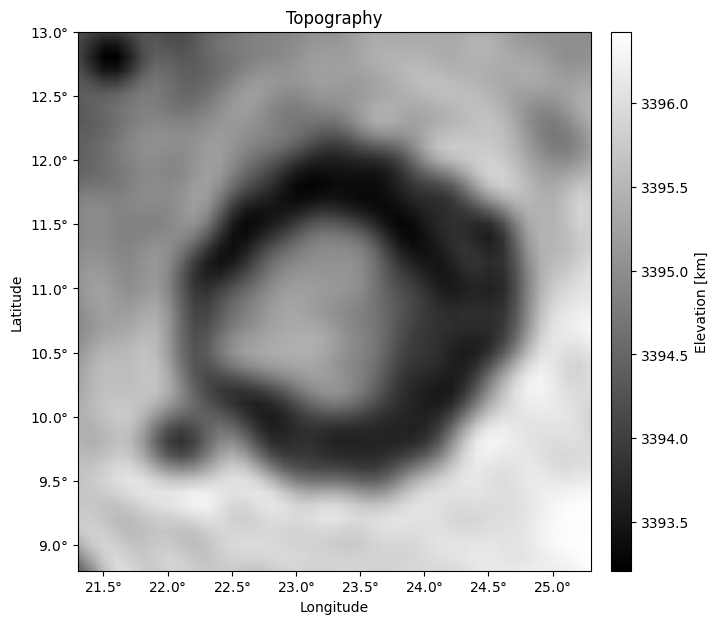

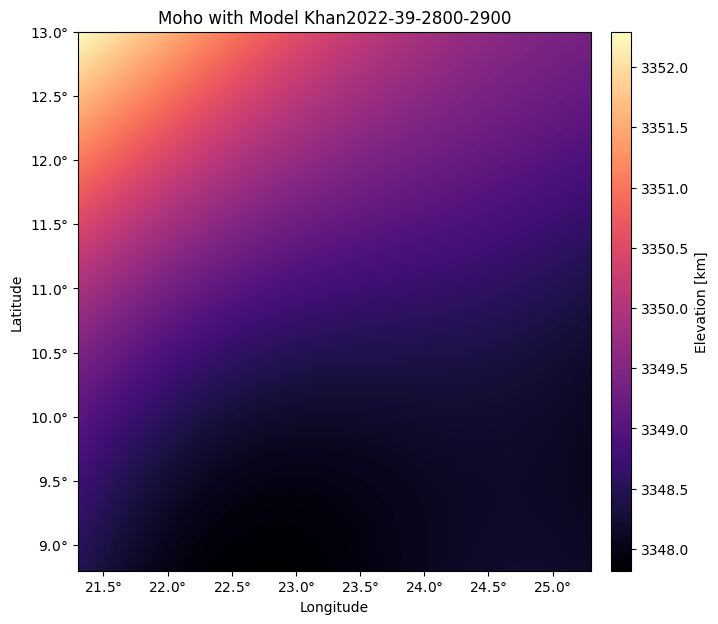

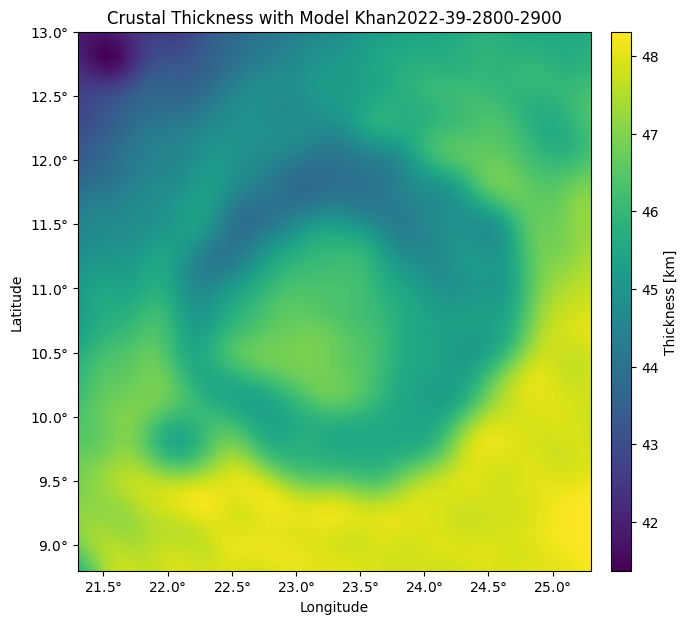

In [5]:
lon = (21.3,25.3)
lat = (8.8,13)

Crust.visualize('topo', lon_bounds=lon, lat_bounds=lat, grid_spacing=0.01)
Crust.visualize('moho', lon_bounds=lon, lat_bounds=lat, grid_spacing=0.01)
Crust.visualize('thick', lon_bounds=lon, lat_bounds=lat, grid_spacing=0.01)

In [6]:
Crust.get_current_model()

{'grid_spacing': 0.1,
 'lmax': 899,
 'RIM_str': 'Khan2022',
 'insight_thickness': 39,
 'rho_north': 2900,
 'rho_south': 2800,
 'model_name': 'Khan2022-39-2800-2900'}

In [7]:
Crust.get('topo', 10, 10)

3394.3555408686307

In [23]:
# Crust.visualize('topo', lon_bounds=(-50,50), lat_bounds=(-50,50), grid_spacing=0.5, colormap='binary_r')
# Crust.visualize('topo', lon_bounds=(21.3,25.3), lat_bounds=(8.8,13), grid_spacing=0.01, colormap='binary_r')

In [7]:
# Crust.load_topo(grid_spacing=0.05)
# Crust.visualize('topo', colormap='binary_r', lon_bounds=(21.3,25.3), lat_bounds=(8.8,13), grid_spacing=0.01)

True

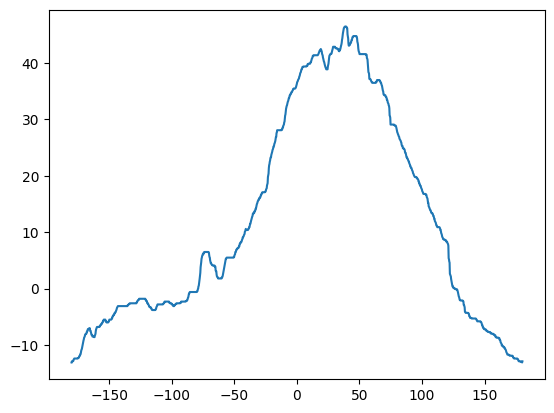

In [62]:
import pooch
import gdown
import numpy as np
from redplanet import utils

def download_gdrive_file(url, output_file, pooch):
    '''Helper for `pooch.retrieve` to allow for downloading from Google Drive.'''
    gdown.download(url, output_file, quiet=True, fuzzy=True)



'''load dichotomy coordinates'''

filepath = pooch.retrieve(
    url=r'https://drive.google.com/file/d/17exPNRMKXGwa3daTEBN02llfdya6OZJY/view?usp=sharing',
    known_hash='sha256:42f2b9f32c9e9100ef4a9977171a54654c3bf25602555945405a93ca45ac6bb2',
    path=pooch.os_cache('redplanet'),
    downloader=download_gdrive_file,
)

# global dichotomy_coords
dichotomy_coords = np.loadtxt(filepath)

dichotomy_coords[:,0] = utils.clon2lon(dichotomy_coords[:,0])
edge = np.where(dichotomy_coords[:,0] == -180)[0][0]
dichotomy_coords = np.vstack((dichotomy_coords[edge:], dichotomy_coords[:edge]))
dichotomy_coords = np.vstack((dichotomy_coords, (dichotomy_coords[0,0]+360, dichotomy_coords[0,1]), (dichotomy_coords[1,0]+360, dichotomy_coords[1,1]) ))


lon = 0
lat = 37



plt.plot(dichotomy_coords[:,0], dichotomy_coords[:,1])

i_lon = np.searchsorted(dichotomy_coords[:,0], lon, side='right') - 1
llon, llat = dichotomy_coords[i_lon]
rlon, rlat = dichotomy_coords[i_lon+1]
tlat = llat + (rlat-llat)*( (lon-llon)/(rlon-llon) )

lat > tlat

array([[-180.     ,  -13.1    ],
       [-179.75443,  -12.9    ],
       [-179.50887,  -12.9    ],
       ...,
       [ 179.75443,  -13.     ],
       [-180.     ,  -13.1    ],
       [ 179.75443,  -13.     ]])

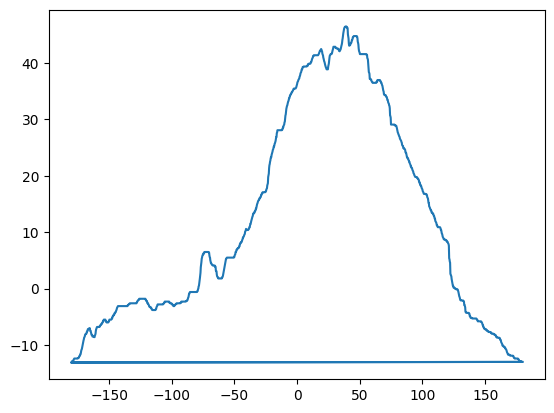

In [13]:
def test(*args):
    if len(args) == 0:
        args = (1,2)
    for arg in args:
        print(arg)

test()

1
2


In [14]:
import pyshtools as pysh

filepath = r'C:\Users\Eris\Downloads\MarsTopo2600.shape.gz'

grid_spacing=0.1
lmax = round(90. / grid_spacing - 1)

topo = pysh.SHCoeffs.from_file(filepath, lmax=lmax, name='MarsTopo2600', units='m', encoding='utf-8')

In [16]:
import pooch
import gdown

def download_gdrive_file(url, output_file, pooch):
    '''Helper for `pooch.retrieve` to allow for downloading from Google Drive.'''
    gdown.download(url, output_file, quiet=True, fuzzy=True)


filepath = pooch.retrieve(
    url=r'https://drive.google.com/file/d/1-g3ipbHd_7bvSbtf2w45u9AnBWoIaUZA/view?usp=sharing',
    known_hash='sha256:45e047a645ae8d1bbd8e43062adab16a22786786ecb17d8e44bfc95f471ff9b7',
    path=pooch.os_cache('redplanet'),
    downloader=download_gdrive_file,
    processor=pooch.Unzip(),
)

Unzipping contents of 'C:\Users\Eris\AppData\Local\redplanet\redplanet\Cache\b7e040df25da7ca9464accd20d033b70-view' to 'C:\Users\Eris\AppData\Local\redplanet\redplanet\Cache\b7e040df25da7ca9464accd20d033b70-view.unzip'


In [24]:
import os

filename = os.path.basename(filepath[0])

filename.split('_')[0]

'Al'